<a href="https://colab.research.google.com/github/tangshuting/daytoy/blob/master/1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pickle
import numpy as np
from scipy import integrate
import os,random
#os.environ["KERAS_BACKEND"] = "theano"
os.environ["KERAS_BACKEND"] = "tensorflow"

from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, random, sys, keras

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount('/content/drive')
f = open(r'/content/drive/My Drive/EMW/2016.04C.multisnr.pkl','rb') 
dataDict = pickle.load(f,encoding='bytes')
print(type(dataDict))   # dict
print(len(dataDict))  #220=11（类别）×20（20个snr）
# snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], dataDict.keys())))), [1,0])


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
<class 'dict'>
220


In [4]:
data = []
labels = []
for d in dataDict:
   signals=dataDict[d]
   for s in signals:
     data.append(np.array(s))
     labels.append(d)
data = np.array(data)
labels = np.array(labels)
print(data.shape) 
print(labels.shape)
print(labels)


(162060, 2, 128)
(162060, 2)
[[b'QPSK' b'2']
 [b'QPSK' b'2']
 [b'QPSK' b'2']
 ...
 [b'WBFM' b'12']
 [b'WBFM' b'12']
 [b'WBFM' b'12']]


In [5]:
# # 使用函数分测试集和训练集
# from sklearn.model_selection import train_test_split
# xTrain, xTest, yTrain, yTest = train_test_split(data,labels, test_size=0.5, random_state=1)

# 手动分测试集和训练集
indices = random.sample(range(0,162060),162060)
xTrain = []
yTrain = []
iTrain = []
for i in range(0,81030):
  xTrain.append(data[indices[i]])
  yTrain.append(labels[indices[i]])
  iTrain.append(indices[i])
xTrain = np.array(xTrain)
yTrain = np.array(yTrain)
iTrain = np.array(iTrain)

xTest = []
yTest = []
iTest = []
for i in range(81030, 162060):
  xTest.append(data[indices[i]])
  yTest.append(labels[indices[i]])
  iTest.append(indices[i])
xTest = np.array(xTest)
yTest = np.array(yTest)
iTest = np.array(iTest)  

print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
# print(iTrain.shape)
# print(iTest.shape)

(81030, 2, 128)
(81030, 2)
(81030, 2, 128)
(81030, 2)


In [6]:
# one-hot 编码
#Sklearn’s one hot encoder doesn’t actually know how to convert categories to numbers, 
#it only knows how to convert numbers to binary. We have to use the labelencoder first.
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
le = LabelEncoder()

# 取出数据中的SNR标签
yTrain_SNR = yTrain[:,1]
yTest_SNR = yTest[:,1]
print('SNR标签')
print(yTrain_SNR.shape)
print(yTest_SNR.shape)
print(yTrain_SNR)
print(yTest_SNR)
#随便找一个数据看一下输出结果是否正确
print(yTest[81028]) 
print(yTest_SNR[81028])

# 取出mod标签
yTrain_mods = yTrain[:,0]
yTest_mods = yTest[:,0]
print('mods标签')
print(yTrain_mods.shape)
print(yTest_mods.shape)
print(yTrain_mods)
print(yTest_mods)

# label编码
yTrain_le = le.fit_transform(yTrain[:, 0])
yTest_le = le.fit_transform(yTest[:, 0])
print('label编码后')
print(yTrain_le.shape)
print(yTest_le.shape)
print(yTrain_le[81028])
print(yTest_le[81028])   

yTrain_le = yTrain_le.reshape(len(yTrain_le), 1)
yTest_le = yTest_le.reshape(len(yTest_le), 1)

# one-hot编码
enc = OneHotEncoder(categories = 'auto',sparse = False )  #将分类特征的每个元素转化为一个可以用来计算的值
yTrain_ohe = enc.fit_transform(yTrain_le)  # 如果不加 toarray() 的话，输出的是稀疏的存储格式，即索引加值的形式，也可以通过参数指定 sparse = False 来达到同样的效果
yTest_ohe = enc.fit_transform(yTest_le)
print('onehot编码后')
print(yTrain_ohe[81028])  
print(yTest_ohe[81028]) 

SNR标签
(81030,)
(81030,)
[b'4' b'-12' b'-4' ... b'-12' b'10' b'-2']
[b'6' b'14' b'14' ... b'-10' b'-2' b'18']
[b'GFSK' b'-2']
b'-2'
mods标签
(81030,)
(81030,)
[b'QPSK' b'QPSK' b'BPSK' ... b'CPFSK' b'WBFM' b'BPSK']
[b'BPSK' b'PAM4' b'QAM16' ... b'QPSK' b'GFSK' b'AM-SSB']
label编码后
(81030,)
(81030,)
10
5
onehot编码后
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [7]:
"""# **Fully Connected Neural Network**
## Load Data (Reformated)
"""
import numpy as np

# 全连接网络 将数据（2，128）转换为（256，）
xTrain_reforamted = []
for i in range(0,xTrain.shape[0]):
  xTrain_reforamted.append(np.concatenate((xTrain[i,0,:] , xTrain[i,1,:]), axis=0))  
xTrain_reforamted = np.array(xTrain_reforamted) 
print("Reformated Train size")
print(xTrain_reforamted.shape)

xTest_reforamted = []
for i in range(0,xTest.shape[0]):
  xTest_reforamted.append(np.concatenate((xTest[i,0,:] , xTest[i,1,:]), axis=0)) 
xTest_reforamted = np.array(xTest_reforamted)  
print("Reformated Test size")
print(xTest_reforamted.shape)
  
print("xTrain Size")
print(xTrain_reforamted.shape)
print("yTrain Size")
print(yTrain_ohe.shape)
print("yTest Size")
print(yTest_ohe.shape)


Reformated Train size
(81030, 256)
Reformated Test size
(81030, 256)
xTrain Size
(81030, 256)
yTrain Size
(81030, 11)
yTest Size
(81030, 11)


In [0]:
# 全连接网络
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.callbacks import ModelCheckpoint

In [9]:
# 搭建模型
model = Sequential()
model.add(Dense(512, input_dim=256, activation='relu'))
model.add(Dense(135, activation='relu'))
model.add(Dense(11, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 135)               69255     
_________________________________________________________________
dense_3 (Dense)              (None, 11)                1496      
Total params: 202,335
Trainable params: 202,335
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
# checkpoint
filepath="/content/drive/My Drive/EMW/best.hdf5weights.best.hdf5"  #保存到挂载的谷歌云盘
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [11]:
# Fit the model
epochs=50
batch_size=1000
history = model.fit(xTrain_reforamted, yTrain_ohe, validation_split=0.2,shuffle=True, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, verbose=1)
# model.fit(xTrain_reforamted, yTrain_ohe, shuffle=True, epochs=1, batch_size=256, callbacks=callbacks_list, verbose=0)

Train on 64824 samples, validate on 16206 samples
Epoch 1/50
64824/64824 [==============================] - 2s 31us/step - loss: 4.0747 - accuracy: 0.1786 - val_loss: 2.2742 - val_accuracy: 0.2155
Epoch 2/50
 6000/64824 [=>............................] - ETA: 1s - loss: 2.2384 - accuracy: 0.2187

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


64824/64824 [==============================] - 2s 26us/step - loss: 2.1939 - accuracy: 0.2349 - val_loss: 2.2111 - val_accuracy: 0.2448
Epoch 3/50
64824/64824 [==============================] - 2s 26us/step - loss: 2.1144 - accuracy: 0.2563 - val_loss: 2.1617 - val_accuracy: 0.2508
Epoch 4/50
64824/64824 [==============================] - 2s 27us/step - loss: 2.0416 - accuracy: 0.2818 - val_loss: 2.1248 - val_accuracy: 0.2941
Epoch 5/50
64824/64824 [==============================] - 2s 27us/step - loss: 1.9652 - accuracy: 0.3212 - val_loss: 2.0705 - val_accuracy: 0.3175
Epoch 6/50
64824/64824 [==============================] - 2s 27us/step - loss: 1.8708 - accuracy: 0.3441 - val_loss: 2.0101 - val_accuracy: 0.3357
Epoch 7/50
64824/64824 [==============================] - 2s 28us/step - loss: 1.7663 - accuracy: 0.3733 - val_loss: 1.9462 - val_accuracy: 0.3617
Epoch 8/50
64824/64824 [==============================] - 2s 26us/step - loss: 1.6357 - accuracy: 0.4203 - val_loss: 1.8536 - val

In [12]:
#evaluating our model on the taining set can help us to determine how much the model overfitt/ underfits the data

print("Testing on test set")
score = model.evaluate(xTest_reforamted, yTest_ohe)
print("\n%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

Testing on test set
81030/81030 [==============================] - 3s 36us/step

accuracy: 57.68%


In [20]:
# 20种SNR
import numpy as np
SNR = np.unique(labels[:,1])
SNR = list(map(int, SNR))
SNR.sort()
SNR = list(map(str, SNR))
print(SNR)

yTest_SNR_str = []
for i in yTest_SNR:
  yTest_SNR_str.append(str(i).split('\'')[1])
print(yTest_SNR_str)

# 11种调制方法
mods = np.unique(labels[:,0])
mods = list(map(str, mods))
mods.sort()
mods = list(map(str, mods))
print(mods)


yTest_mods_str = []
for i in yTest_mods:
  yTest_mods_str.append(str(i).split('\'')[1])
print(yTest_mods_str)

['-20', '-18', '-16', '-14', '-12', '-10', '-8', '-6', '-4', '-2', '0', '2', '4', '6', '8', '10', '12', '14', '16', '18']
['6', '14', '14', '-14', '-14', '-2', '16', '-10', '6', '-16', '18', '10', '2', '-12', '12', '-4', '16', '-2', '12', '16', '-6', '6', '4', '-16', '4', '-14', '-12', '-12', '12', '-8', '-12', '2', '8', '4', '2', '16', '-6', '18', '-16', '10', '-16', '12', '-6', '-16', '-6', '-18', '10', '-20', '6', '8', '14', '-12', '-2', '-14', '0', '-14', '4', '-4', '-12', '6', '-8', '4', '16', '6', '-20', '-16', '-20', '8', '16', '8', '4', '12', '8', '10', '-12', '-2', '-14', '6', '-10', '-2', '8', '-14', '-14', '14', '8', '16', '14', '18', '6', '14', '10', '6', '-8', '-12', '-18', '2', '-2', '-6', '-10', '16', '0', '-20', '-6', '-10', '2', '16', '-8', '-20', '18', '-14', '-20', '-20', '-12', '18', '4', '2', '6', '-8', '-6', '12', '8', '-10', '-18', '12', '2', '16', '18', '-18', '18', '4', '12', '2', '14', '10', '-6', '6', '12', '6', '8', '16', '6', '14', '-16', '4', '18', '-14', 

Accuracy for SNR =  -20  is  11.31843850016594
Accuracy for SNR =  -18  is  11.992119997739792
Accuracy for SNR =  -16  is  11.830081790685654
Accuracy for SNR =  -14  is  13.67245614528656
Accuracy for SNR =  -12  is  16.412025690078735
Accuracy for SNR =  -10  is  19.50337439775467
Accuracy for SNR =  -8  is  31.34179711341858
Accuracy for SNR =  -6  is  47.6826012134552
Accuracy for SNR =  -4  is  62.44787573814392
Accuracy for SNR =  -2  is  72.62791991233826
Accuracy for SNR =  0  is  82.95369148254395
Accuracy for SNR =  2  is  82.6417863368988
Accuracy for SNR =  4  is  84.7000002861023
Accuracy for SNR =  6  is  82.72727131843567
Accuracy for SNR =  8  is  86.76869869232178
Accuracy for SNR =  10  is  88.18272352218628
Accuracy for SNR =  12  is  88.72218132019043
Accuracy for SNR =  14  is  82.92563557624817
Accuracy for SNR =  16  is  86.50214076042175
Accuracy for SNR =  18  is  90.81807136535645


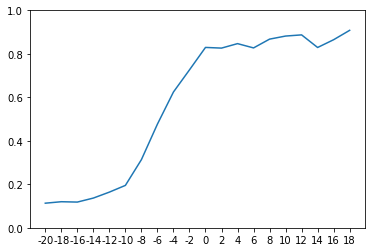

In [14]:
"""# Accuracy Plot"""

from keras.models import load_model
# saved_model = load_model('/content/drive/My Drive/EMW/best.hdf5weights.best.hdf5')
saved_model = load_model(filepath)

accuracy = []

for s in SNR:
    SNR_index = []
    SNR_Y = []
    SNR_X = []
    for index in range(0,len(yTest_SNR_str)):
        if s == yTest_SNR_str[index]:
            SNR_index.append(index)
            SNR_Y.append(yTest_ohe[index])
            SNR_X.append(xTest_reforamted[index])

    y = np.array(SNR_Y)
    x = np.array(SNR_X)
    result = model.evaluate(x, y,verbose=0)
    print('Accuracy for SNR = ', s, ' is ', result[1] * 100)
    accuracy.append(result[1])    
import matplotlib.pyplot as plt
plt.plot(SNR, accuracy)
plt.xlabel('Signal-to-noise ratio')
plt.ylabel('Accuarcy')
plt.title('The classification of modulation ')
plt.show()

Accuracy for SNR =  -20 dB is  11.31843850016594
Accuracy for SNR =  -18 dB is  11.992119997739792
Accuracy for SNR =  -16 dB is  11.830081790685654
Accuracy for SNR =  -14 dB is  13.67245614528656
Accuracy for SNR =  -12 dB is  16.412025690078735
Accuracy for SNR =  -10 dB is  19.50337439775467
Accuracy for SNR =  -8 dB is  31.34179711341858
Accuracy for SNR =  -6 dB is  47.6826012134552
Accuracy for SNR =  -4 dB is  62.44787573814392
Accuracy for SNR =  -2 dB is  72.62791991233826
Accuracy for SNR =  0 dB is  82.95369148254395
Accuracy for SNR =  2 dB is  82.6417863368988
Accuracy for SNR =  4 dB is  84.7000002861023
Accuracy for SNR =  6 dB is  82.72727131843567
Accuracy for SNR =  8 dB is  86.76869869232178
Accuracy for SNR =  10 dB is  88.18272352218628
Accuracy for SNR =  12 dB is  88.72218132019043
Accuracy for SNR =  14 dB is  82.92563557624817
Accuracy for SNR =  16 dB is  86.50214076042175
Accuracy for SNR =  18 dB is  90.81807136535645


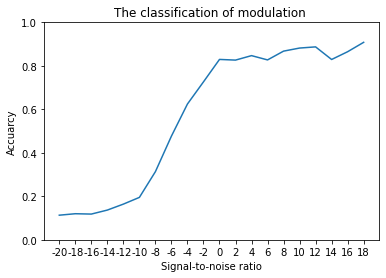

In [23]:
"""# Accuracy Plot"""

from keras.models import load_model
# saved_model = load_model('/content/drive/My Drive/EMW/best.hdf5weights.best.hdf5')
saved_model = load_model(filepath)

accuracy = []
# for m in mods:
for s in SNR:
    SNR_index = []
    SNR_Y = []
    SNR_X = []
    for index in range(0,len(yTest_SNR_str)):
        if s == yTest_SNR_str[index]:
            SNR_index.append(index)
            SNR_Y.append(yTest_ohe[index])
            SNR_X.append(xTest_reforamted[index])

    y = np.array(SNR_Y)
    x = np.array(SNR_X)
    result = model.evaluate(x, y,verbose=0)
    print('Accuracy for SNR = ', s, 'dB is ', result[1] * 100)
    accuracy.append(result[1])   
 
import matplotlib.pyplot as plt
plt.ylim(0, 1)
plt.plot(SNR, accuracy)
plt.xlabel('Signal-to-noise ratio')
plt.ylabel('Accuarcy')
plt.title('The classification of modulation ')
plt.show()

In [15]:
import keras
from keras import backend as K
import numpy as np
# predict()预测概率，numpy.axgmax()找到样本最大概率所属类别作为样本预测标签，，predict_classes()返回类别索引即该样本所属的类别标签,只用于sequential model（搭建模型有两种方法）
eps = 0.2
for s in SNR:
    SNR_index = []
    SNR_Y = []
    SNR_X = []
    for index in range(0,len(yTest_SNR_str)):
        if s == yTest_SNR_str[index]:
            SNR_index.append(index)
            SNR_Y.append(yTest_ohe[index])
            SNR_X.append(xTest_reforamted[index])

    y = np.array(SNR_Y)
    x = np.array(SNR_X)
  
    # prediction=model.predict(x)
    loss=keras.losses.categorical_crossentropy(y,model.output)
    gradient=K.gradients(loss,model.input)
    sign_grad = K.sign(gradient[0])
    adv = x + eps*sign_grad
    result2 = model.evaluate(adv,y, verbose=2)
    accuracy.append(result2[1])
import matplotlib.pyplot as plt
plt.ylim(0, 1)
plt.plot(SNR, accuracy)
plt.show()


ValueError: ignored